In [8]:
import matplotlib.pyplot as plt
import matplotlib
from collections import Counter
%matplotlib inline
from collections import *
from random import random
import nltk, re, pprint
from nltk import word_tokenize, sent_tokenize
from collections import Counter
import numpy as np
import re
from nltk.probability import FreqDist

# Assignment 1: 
# Topics in Natural Language Processing (202-2-5381) Fall 2018
# Prof. Michael Elhadad

### Author: Dina Svetlitsky

[Assignment description](https://www.cs.bgu.ac.il/~elhadad/nlp18/hw1.html)

## Part 1: Language Models

In this part, we will develop two language models and evaluate the performance of the models.

### 1.1 Data Exploration

#### 1.1.1 Gathering and Cleaning Up Data

First, lets get some data (the book War and Peace be Leo Tolstoy, which I downloaded from Project Gutenberg):

In [9]:
input_text_file = open("war_and_peace.txt", "r", encoding="utf8")
text = input_text_file.read()

A quick peek into the text:

In [10]:
text[30000:31000]

'ubt my ability before such an audience,” said he,\nsmilingly inclining his head.\n\nThe princess rested her bare round arm on a little table and considered\na reply unnecessary. She smilingly waited. All the time the story was\nbeing told she sat upright, glancing now at her beautiful round arm,\naltered in shape by its pressure on the table, now at her still more\nbeautiful bosom, on which she readjusted a diamond necklace. From time\nto time she smoothed the folds of her dress, and whenever the story\nproduced an effect she glanced at Anna Pávlovna, at once adopted just\nthe expression she saw on the maid of honor’s face, and again relapsed\ninto her radiant smile.\n\nThe little princess had also left the tea table and followed Hélène.\n\n“Wait a moment, I’ll get my work.... Now then, what are you\nthinking of?” she went on, turning to Prince Hippolyte. “Fetch me my\nworkbag.”\n\nThere was a general movement as the princess, smiling and talking\nmerrily to everyone at once, sat down

Replace wierd quotation or apostrophe:

In [11]:
s = "he said: “don‘t”"
s = re.sub("‘|’", "\'", s)
s = re.sub("“|”", '\"', s)
print(s)

he said: "don't"


In [12]:
text = re.sub("‘|’", "\'", text)
text = re.sub("“|”", '\"', text)
text = re.sub("``", "''", text)

text[30000:31000]

'ubt my ability before such an audience," said he,\nsmilingly inclining his head.\n\nThe princess rested her bare round arm on a little table and considered\na reply unnecessary. She smilingly waited. All the time the story was\nbeing told she sat upright, glancing now at her beautiful round arm,\naltered in shape by its pressure on the table, now at her still more\nbeautiful bosom, on which she readjusted a diamond necklace. From time\nto time she smoothed the folds of her dress, and whenever the story\nproduced an effect she glanced at Anna Pávlovna, at once adopted just\nthe expression she saw on the maid of honor\'s face, and again relapsed\ninto her radiant smile.\n\nThe little princess had also left the tea table and followed Hélène.\n\n"Wait a moment, I\'ll get my work.... Now then, what are you\nthinking of?" she went on, turning to Prince Hippolyte. "Fetch me my\nworkbag."\n\nThere was a general movement as the princess, smiling and talking\nmerrily to everyone at once, sat do

word_tokenize is a helpful function for text tokenization:

In [13]:
tokens = word_tokenize(text)

How many tokens do we have?

In [14]:
len(tokens)

668651

Lets look at the first few tokens:

In [15]:
tokens[:10]

['\ufeff',
 'The',
 'Project',
 'Gutenberg',
 'EBook',
 'of',
 'War',
 'and',
 'Peace',
 ',']

It is pretty good, but we want to get rid of punctuations and tokens in lower case:

In [16]:
PUNCTUATION = r"...?!:;--()[]\''\",``"
tokens = [token.lower() for token in tokens if token not in PUNCTUATION]

Now we have less tokens:

In [17]:
len(tokens)

572491

We can put our tokens in a Counter data structure, which will count occurrences of each token:

In [18]:
tokens_counter = Counter(tokens)

How many distinct tokens do we have?

In [19]:
len(tokens_counter)

20519

Now lets take just the 10,000 most commons tokens, we will use it in cleaning up the data:

In [20]:
most_common_tokens = tokens_counter.most_common(10000)
most_common_tokens[:10]

[('the', 34556),
 ('and', 22150),
 ('to', 16706),
 ('of', 14990),
 ('a', 10491),
 ('he', 9930),
 ('in', 8928),
 ('that', 8067),
 ('his', 7966),
 ('was', 7339)]

Now, we want to seperate our text to sentences, and then each sentence to tokens. We can use nltk.sent_tokenize

In [21]:
sents = nltk.sent_tokenize(text)
sents = [word_tokenize(sent) for sent in sents]
sents[0]

['\ufeff',
 'The',
 'Project',
 'Gutenberg',
 'EBook',
 'of',
 'War',
 'and',
 'Peace',
 ',',
 'by',
 'Leo',
 'Tolstoy',
 'This',
 'eBook',
 'is',
 'for',
 'the',
 'use',
 'of',
 'anyone',
 'anywhere',
 'at',
 'no',
 'cost',
 'and',
 'with',
 'almost',
 'no',
 'restrictions',
 'whatsoever',
 '.']

We also want to mark numbers as 'N':

In [22]:
NUMBERS = '0123456789'
n1 = "123"
n2 = "800.7655"
print(re.sub('\d+\.\d+|\d+', 'N', n1))
print(re.sub('\d+\.\d+|\d+', 'N', n2))

N
N


All good. Now we will do everything we have done above, using a general function:

In [23]:
def sent_transformation(sent, most_common_tokens_set):
    """gets a tokenized sentence and returns a cleaned concatanated sentance"""
    cleaned_sentence = []
    for token in sent:
        if token not in PUNCTUATION:
            token = token.lower()
            if re.search('\d', token):
                token = re.sub('\d+\.\d+|\d+', 'N', token)#replace numbers with 'N'
            else:
                if token not in most_common_tokens_set:
                    token = "<unk>"
            cleaned_sentence.append(token)
    return " ".join(cleaned_sentence)

Test our sent_transformation

In [24]:
sent = "Buonapartes. But I warn you, if you don't tell me that this means war."
print(word_tokenize(sent))
sent_transformation(word_tokenize(sent), set([item[0] for item in most_common_tokens]))

['Buonapartes', '.', 'But', 'I', 'warn', 'you', ',', 'if', 'you', 'do', "n't", 'tell', 'me', 'that', 'this', 'means', 'war', '.']


"<unk> but i warn you if you do n't tell me that this means war"

In [25]:
def get_common_tokens_set(text, top):
    """tokenized text to lowercase tokens without punctuations, returns a set of the top most common tokens"""
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens if token not in PUNCTUATION]#remove punctuation and lowecase
    tokens_counter = Counter(tokens)
    most_common_tokens = tokens_counter.most_common(top)
    
    return set([item[0] for item in most_common_tokens])

In [26]:
def process_file(filename, top):
    input_text_file = open(filename, "r", encoding="utf8")
    text = input_text_file.read()
    
    common_tokens_set = get_common_tokens_set(text, top)
    
    sents = nltk.sent_tokenize(text)
    sents = [word_tokenize(sent) for sent in sents]
    
    output_file = open(filename+".out", "w", encoding="utf8")
    for sent in sents:
        output_file.write(sent_transformation(sent, common_tokens_set) + "\n")
    output_file.close()

ptb_preprocess takes a list of filenames and for each file dataset:
- Keeps only the top most frequent words in the dataset
- Replaces all numbers by the token N
- Tokenizes the words
- Removes all punctuations
- Segments the sentencess and prints them one by line
- Outputs all the text in lowercase

In [27]:
def ptb_preprocess(filenames, top=10000):
    for filename in filenames:
        process_file(filename, top)

In [28]:
ptb_preprocess(["war_and_peace.txt"])

Lets look at some cleaned sentences from the file that was created:

In [29]:
output_file = open("war_and_peace.txt.out", "r", encoding="utf8")
text = output_file.readlines()
text[5:8]

['with these words she greeted prince vasíli kurágin a man of high rank and importance who was the first to arrive at her reception\n',
 'anna pávlovna had had a cough for some days\n',
 'she was as she said suffering from la grippe grippe being then a new word in st. petersburg used only by the <unk>\n']

Great!

#### 1.1.2 Gathering Basic Statistics

The Penn Tree Bank (PTB) dataset, which contains 929k training words, 73k validation words, and 82k test words, was peocessed by Tomas Mikolov in the same way as in part 1.1.2.

We will get the train, validation and test data of words and characters.

Sentences data:

In [30]:
input_dataset_file_train = open(r"penn_treebank\data\ptb.train.txt", "r", encoding="utf8")
input_dataset_file_valid = open(r"penn_treebank\data\ptb.valid.txt", "r", encoding="utf8")
input_dataset_file_test = open(r"penn_treebank\data\ptb.test.txt", "r", encoding="utf8")
words_train_data = input_dataset_file_train.read()
words_valid_data = input_dataset_file_valid.read()
words_test_data = input_dataset_file_test.read()

Characters data:

In [31]:
input_dataset_file_train = open(r"penn_treebank\data\ptb.char.train.txt", "r", encoding="utf8")
input_dataset_file_valid = open(r"penn_treebank\data\ptb.char.valid.txt", "r", encoding="utf8")
input_dataset_file_test = open(r"penn_treebank\data\ptb.char.test.txt", "r", encoding="utf8")
chars_train_data = input_dataset_file_train.read()
chars_valid_data = input_dataset_file_valid.read()
chars_test_data = input_dataset_file_test.read()

Lets look at some sentences in the train dataset:

In [32]:
sents = words_train_data.split("\n")
sents[:3]

[' aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter ',
 ' pierre <unk> N years old will join the board as a nonexecutive director nov. N ',
 ' mr. <unk> is chairman of <unk> n.v. the dutch publishing group ']

And some tokens:

In [33]:
tokens = words_train_data.split()
tokens[:10]

['aer',
 'banknote',
 'berlitz',
 'calloway',
 'centrust',
 'cluett',
 'fromstein',
 'gitano',
 'guterman',
 'hydro-quebec']

First we gather statistics on words:

Total number of tokens:

In [34]:
len(tokens)

887521

In [35]:
token_counter = Counter(tokens)

Total number of distinct words:

In [36]:
len(token_counter)

9999

token/word ratio:

In [37]:
len(tokens)/float(len(token_counter))

88.76097609760976

Each token repeats 88 times on average

In [38]:
sum([item[1] for item in token_counter.most_common(1000)])/float(len(tokens))

0.7821775484749093

1000 most frequent words correspond to almost 80% of the data

Average number of characters per token:

In [39]:
np.average([len(token) for token in tokens])

4.6533670752579379

Standard deviation of number of charachters per token:

In [40]:
np.std([len(token) for token in tokens])

2.6019161500774306

Now we will plot the number of distinct word ngrams:

In [41]:
def distinct_ngrams(tokens, n):
    nmers = Counter()
    for i in range(len(tokens)-n):
        nmer = " ".join(tokens[i:i+n])
        nmers[nmer] += 1
    return len(nmers)

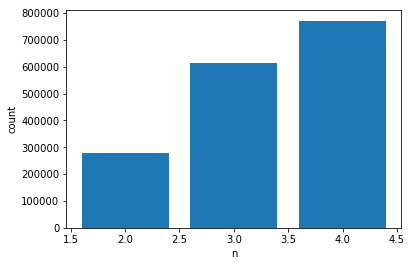

In [42]:
plt.bar([2,3,4], [distinct_ngrams(tokens, n) for n in [2,3,4]])
plt.xlabel("n")
plt.ylabel("count")

What happens if we plot of the log-frequency of words against the log-rank of words?

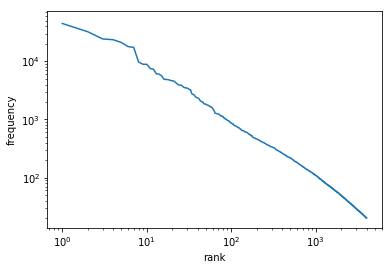

In [43]:
plt.loglog([val for word,val in token_counter.most_common(4000)])
plt.xlabel('rank')
plt.ylabel('frequency');

The graph is almost linear! It seems that the word count distribution follows power law distribution. A few words occur a lot, many words occur rarely.

Some comparison between the train, valid datasets and the test dataset:

In [44]:
test_tokens = words_test_data.split()
len(set(test_tokens)-set(tokens))

0

In [45]:
valid_tokens = words_valid_data.split()
len(set(valid_tokens)-set(tokens))

0

There are no unseen tokens in the test or validation dataset

Total number of characters:

In [46]:
chars = chars_train_data.split()
len(chars)

4975414

Number of distinct character bigrams:

In [47]:
distinct_ngrams(chars, 2)

958

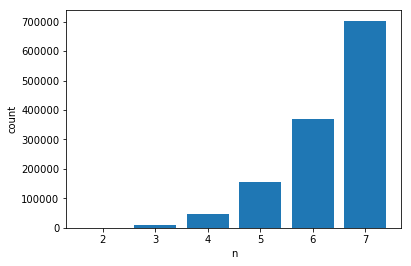

In [48]:
plt.bar([2, 3, 4, 5, 6, 7], [distinct_ngrams(chars, n) for n in [2, 3, 4, 5, 6, 7]])
plt.xlabel("n")
plt.ylabel("count")

The number of distinct character 7-grams is similar the the number of distinct word n-grams.

In [49]:
from nltk.probability import MLEProbDist

### 1.2 n-gram Language Model

In order to use an n-gram model, we need to store all distinct n-grams in memory. For each n-grams, the number of times it occurs.

In the general case, all n-grams in the dataset could be distinct. Hence, if m is the number of tokens, there could be also m distinct 2,3,4...-grams (there are m starting points). So the worst case memory consumption, for m tokens, L average word length and an n-gram model is:
mxnxL.

In this dataset we have ~900,000 tokens, so the number of distinct n-grams could be 900,000xnxl.
However, we can see that there are only 300,000 bi-grams, 600,000 tri-grams and 800,000 4-grams. Larger n increases the number of n-grams but it can't be more than 887,521 (number of tokens).

In [50]:
distinct_ngrams(tokens, 5)

825370

In [51]:
distinct_ngrams(tokens, 6)

846671

And indeed we can see that the number of distinct ngrams converges to the number of tokens from n=4.

Now, let us build the model by simply counting all n-grams in text

In [52]:
def train_word_lm(sents, n=2):
    "constructs a word n-gram model given a dataset of sentences"
    counter = defaultdict(FreqDist)
    for sent in sents:
        pad = ["~" for x in range(n-1)]
        sent = pad + sent + ["~"] #pad from both sided to mark start and end of sentence
        for i in range(len(sent)-n+1):
            history, word = " ".join(sent[i:i+n-1]), sent[i+n-1]
            counter[history][word] += 1
    return counter    

In [53]:
sents_train = words_train_data.split("\n")
sents_train = [sent.split() for sent in sents_train]
lm = train_word_lm(sents_train, n=2)

What do we get for the word 'burned'?

In [54]:
lm['burned']

FreqDist({'a': 1,
          'by': 1,
          'if': 1,
          'in': 1,
          'investors': 1,
          'on': 2,
          'rand': 1,
          'repeatedly': 1,
          'when': 1,
          '~': 1})

We get the number of times different words follow the word burned. But what is the frequenct of 'burned on' given 'burned'? 

In [55]:
lm['burned'].freq('on')

0.18181818181818182

And the frequency of 'm given I?

In [56]:
lm['i'].freq('\'m')

0.10380348652931855

For convenience, the method create_models creates all models from 1 to n. This will make it an easier job to evaluate models for different n values.  

In [57]:
def create_models(sents, n):
    """creates all models from 1 to n"""
    single_word_fd = FreqDist([word for sent in sents for word in sent])
    single_word_fd['~'] = len(sents) #number of times a sentence ends
                            
    models = {1:single_word_fd}
    
    for i in range(2, n+1):
        lm = train_word_lm(sents, i)
        models[i] = lm
        
    return models

### 1.3 Language Model Evaluation

In order to evaluate our model, we will calculate entropy and perplexity (which is simply 2^entropy) on the validation dataset.

But before that, we need to 'fix' our model. What happens if a specific n-gram in the validation dataset was not seen in the training dataset? It will get a probability of 0 and it will not be possible to calculate entropy or perplexity. Therefore, we will need to use some 'smoothing' technique in order to solve this problem.

The simplest smoothing technique is to add k to each ngram count (Lidstone smoothing). When k equals 1 this is the Laplace smoothing.

In [58]:
def prob_MLE_addk_smoothing(history, word, n, models, k=1):
    """
    Lidstone smoothing technique. Add k to each ngram count, seen and unseen.
    Add |V|*k denominator for normalization.
    When k=1 this is the Laplace smoothing
    """
    model = models[n]
    history_str = " ".join(history)
    
    word_count = 0
    history_count = 0
    if n == 1:
        word_count = model[word]
        history_count = model.N()
    else:
        if history_str in model:
            history_count = model[history_str].N()
            if word in model[history_str]:
                word_count = model[history_str][word]
            
    V = len(models[1])#number of types in the unigram model
    prob = (word_count + k)/(history_count + (V*k))
    
    return prob

Now for the caclulation of entropy and perplexity

In [59]:
from math import log
def entropy(sents, n, models, prob_func, alpha=1):
        """
        Calculate the approximate cross-entropy of the n-gram model for a
        given evaluation sentences.
        This is the average log probability of each word in the text.

        :param sents: sentences of tokens to use for evaluation
        :type sents: list(list(str))
        :param n: the n of n-gram model
        :param models: all models from 1 to n. Used for backoff purposes
        :param prob_func: probability function to compute P(word|history)
        :param alpha: hyperparameter
        """
        
        e = 0.0
        N = 0
        for sent in sents:
            pad = ["~" for x in range(n-1)]
            N += len(sent) + len(pad) #include the end of sent tokens to the total count
            sent = pad + sent + pad
            for i in range(len(sent)-n+1):
                history, word = sent[i:i+n-1], sent[i+n-1]
                prob = prob_func(history, word, n, models, alpha)
                if prob != 0:
                    e += log(prob, 2)
        
        return -e / N

In [60]:
def perplexity(sents, n, models, prob_func, alpha=1):
    return 2**entropy(sents, n, models, prob_func, alpha)

Now for the part of measuring our model:

Is perplexity reduced when increasing n?

In [61]:
n = 7
ngram_models = create_models(sents_train, n) #create all ngram models from 1 to n

In [62]:
def compute_perp_diff_models(n, sents, models, prob_func, alpha=1):
    """
    compute perplexity for each ngram model from 2 to n
    """
    perplexities = []

    for i in range(2,n+1):
        p = perplexity(sents, i, models, prob_func, alpha)
        perplexities.append(p)
        
    return perplexities

Let's observe the perplexity results on the validation dataset, using the Laplace smoothing (add 1 to each ngram count)

In [63]:
valid_tokens = [sent.split() for sent in words_valid_data.split("\n")] 
n = 7
perplexities_valid_MLE_laplace_smoothing = compute_perp_diff_models(n, valid_tokens, ngram_models, prob_MLE_addk_smoothing)
perplexities_valid_MLE_laplace_smoothing

[854.5197234923078,
 3283.2826549773554,
 5437.201093406795,
 6395.441836914597,
 6785.036744201539,
 6971.589331987894]

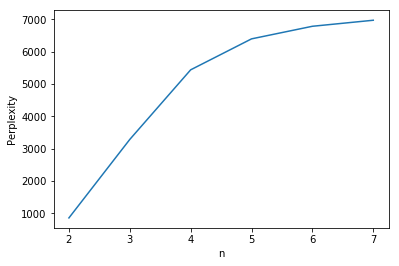

In [64]:
plt.plot(range(2,8), perplexities_valid_MLE_laplace_smoothing)
plt.xlabel("n")
plt.ylabel("Perplexity")

The perplexity is ok for n=2, but it should be improved with larger ngram model and it doesn't.

Maybe adding k<1 could improve that. We will try to improve perplexity on n=2. 

In [65]:
valid_tokens = [sent.split() for sent in words_valid_data.split("\n")] 
n = 2
perplexities_valid_MLE_addk_n2 = []
for k in np.arange(0.1, 1.0, 0.1):
    p = perplexity(valid_tokens, n, ngram_models, prob_MLE_addk_smoothing, k)
    perplexities_valid_MLE_addk_n2.append(p)
perplexities_valid_MLE_addk_n2

[399.46742337770513,
 481.4238597127433,
 547.069482374209,
 603.5264664100564,
 653.8614059439122,
 699.7286350257758,
 742.143075784467,
 781.7815304713514,
 819.1225835710153]

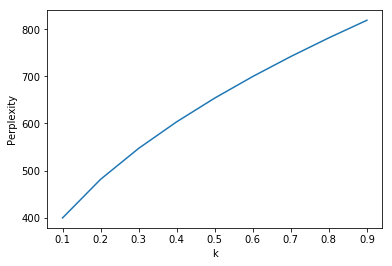

In [66]:
plt.plot(np.arange(0.1, 1.0, 0.1), perplexities_valid_MLE_addk_n2)
plt.xlabel("k")
plt.ylabel("Perplexity")

best result is achieved with k=0.1. Lets run again the add k smoothing when k=0.1 for different n values.

In [67]:
valid_tokens = [sent.split() for sent in words_valid_data.split("\n")] 
n = 7
perplexities_valid_MLE_addk_smoothing = compute_perp_diff_models(n, valid_tokens, ngram_models, prob_MLE_addk_smoothing, 0.1)
perplexities_valid_MLE_addk_smoothing

[399.46742337770513,
 1682.285009191801,
 3742.725919384281,
 5029.421202042892,
 5631.551100383158,
 5933.2598196671]

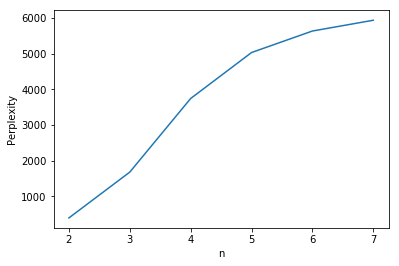

In [68]:
plt.plot(range(2,8), perplexities_valid_MLE_addk_smoothing)
plt.xlabel("n")
plt.ylabel("Perplexity")

Still, the best perplexity is for n=2.
I think it happens because of the smoothing method we used, the add k smoothing underestimates P(word|history) when n grows. As n grows, there are more words that are not seen in the context of some long history. The more appropriate smoothing would be a backoff smoothing such as Katz backoff.

Now it is time to test our model on the test dataset.

In [69]:
test_tokens = [sent.split() for sent in words_test_data.split("\n")] 

In [70]:
n=2
k=0.1
perplexity(valid_tokens, n, ngram_models, prob_MLE_addk_smoothing, k)

399.46742337770513

The worst case perplexity is achieved for the uniform distribution, where there is 1/|V| chance for each word in the vocabulary V.

In [71]:
def uniform_prob(history, word, n, models, alpha=1):
    model = models[1]
    
    return 1/len(model)

In [73]:
n = 2
perplexity(test_tokens, n, ngram_models, uniform_prob)

10000.000000135005

As expected, this number coincides with the number of words in the dataset.

The paper ["Breaking the softmax bottleneck: A high-rank RNN language model"](https://arxiv.org/pdf/1711.03953.pdf) by Z. Yang et. al describes a new method to improve an RNN model. The authors compare the results to state of the art results in the last 5 years.

<img src="ptb_ppl_results.png">

The perplexity obtained using the language model I created is better than the worst case, but ~8 time worse than the best models.

In conclusion - Lidstone smoothing has poor results. Maybe because Lidstone smoothing moves too much probability mass to unkown events.

### 1.3.2 Generating Text from a Language Model

Another way to evaluate a language model is to use the model in a generative manner.

Generating a word given the word 'burned' using Maximal Likelihood probability:

In [75]:
ngram_models[2]['burned']

FreqDist({'a': 1,
          'by': 1,
          'if': 1,
          'in': 1,
          'investors': 1,
          'on': 2,
          'rand': 1,
          'repeatedly': 1,
          'when': 1,
          '~': 1})

In [76]:
MLEProbDist(ngram_models[2]['burned']).generate()

'~'

In word generation, we can try to use 'stupid backoff' instead of Lidstone smoothing. If an n-gram is not found, we will try to look for an (n-1)-gram, (n-2)-gram and so on. Eventually we will reach the 1-gram model, and the probability couldn't be 0 as all words in the train data appear in the validation data.

The probelm with this method is that the sum of probabilities will not be equal to 1, so entropy can't be measured. Anyway, lets see if it works in practice.

In [77]:
def prob_stupid_backoff(history, word, n, models, alpha=1):
    """
    If an n-gram is not found, we will try to look for an (n-1)-gram, (n-2)-gram and so on.
    alpha can be used for normalization
    """
    model = models[n]
    
    if n == 1:
        return model.freq(word) #1-gram model is just the frequency of word
    else:
        history_str = " ".join(history)
        if history_str in model and word in model[history_str]:
            return model[history_str].freq(word)
        else:#back-off to shorter history
            return prob_stupid_backoff(history[1:], word, n-1, models)*alpha

In [78]:
def generate_word(models, history, n):
    '''
    generates a word given history using MLE probability 
    if history is not found, back-off for shorter history
    '''
    history = history[-n+1:]
    history_str = " ".join(history)
    
    model = models[n]
   
    if n == 1:
        return MLEProbDist(model[history_str]).generate()
    else:
        if model[history_str].N() > 0:
            mle = MLEProbDist(model[history_str])
            return mle.generate()
        else:#back-off to shorter history
            return generate_word(models, history[1:], n-1)

The generation of words could stop after a perdefined number of words were created.

I think that is is more wise to stop when as end of sentence token is generated

In [82]:
def generate_sent(models, seed, n):
    """
    generates a sentence given a seed using ngram model models[n]
    """
    history = seed
    out = history
    word = generate_word(models, history, n)
    while word != "~": #keep generating words until an "end of sentence" mark
        out.append(word)
        word = generate_word(models, history, n)
        history = history[-n+1:] + [word]
    return " ".join(out)

In [83]:
def generate(models, seed, n, num_of_sents):
    """
    generate num_of_sents sentences using generate_sent
    """
    text = ""
    for i in range(num_of_sents):
        sent = generate_sent(models, seed, n)
        sent = sent.replace("~ ", "")
        sent = sent[0].upper() + sent[1:] + ". "
        text = text + sent
        seed = ["~" for x in range(n-1)]
    return text

Let's see how good our model is in generating sentences:

In [84]:
n=2
generate(ngram_models, ["i"], n, 2)

"I do n't provide structural damage at the N N the upper manhattan community <unk> frame that 's intent is seeking on thursday 's gains after all of the clean slate of the N N N N billion. The editor of $ N despite the network of <unk> the <unk> materials may be made a provision for example the same risk factors and <unk> or N higher on new <unk> added gross national over-the-counter trading is the markets more complex in the gain of <unk> subsidiaries. "

In [86]:
generate(ngram_models, ["~"], n, 2)

"Daniel 's annual sales so high above to N. <unk> formerly owners contend that level of obtaining or N N pieces of seats for individuals still stands people with banks to N in the world series bonds just get tougher for four years. "

It doesn't makes much sense. What if we increase n?

In [87]:
n=3
generate(ngram_models, ["i", "am"], n, 2)

'I am today. N develop rental agreements with reuters <unk> hill is for growth not just for the ninth inning of game four when <unk> earthquake damage may top $ N million respectively. '

In [88]:
n=3
generate(ngram_models, ["~" for x in range(n-1)], n, 2)

"He also noted an absence of <unk> stock-index futures or options. In fiscal N with the chinese government of spain 's nato commitment and in exchange for an <unk> issue of emissions that lead to further advance. "

Not bad, now for n=4:

In [89]:
n=4
generate(ngram_models, ["~" for x in range(n-1)], n, 2)

"He said chrysler fully expects to have them sent home instead. Nevertheless he noted no one will check to determine what the jurors ' attitudes are likely to mirror those mr. bush enacted shortly after the massacre. "

In [90]:
n=5
generate(ngram_models, ["~" for x in range(n-1)], n, 2)

"The company also changed its dividend policy under which holders had received an annual N <unk> payment by declaring a <unk> dividend to be paid quarterly on <unk> shares. According to the report completed last month if china 's trade gap continues to widen at the pace seen in the first seven months and the <unk> deficit widens to $ N billion and is set up to handle precisely the kind of emergency the state faces said tom <unk> the governor 's deputy press secretary. "

In [91]:
n=6
generate(ngram_models, ["~" for x in range(n-1)], n, 2)

"He believed colon cancer might also arise from multiple hits on cancer <unk> genes because it often seems to develop in stages. Democracy is making a return with a <unk> to latin america 's most <unk> and deeply <unk> country. "

In [94]:
n=7
generate(ngram_models, ["~" for x in range(n-1)], n, 2)

"Westinghouse 's own role as a supplier also is changing. Desperate he has called in the <unk> to help fight the rebels of the <unk> national movement in the north which is only one of several groups picking away at the regime in the capital of <unk>. "

The sentences make more sense as n grows. But as n grows, there are less ngrams completions to choose from. For example:

In [97]:
ngram_models[7]["movement in the north which is"]

FreqDist({'only': 1})

The 6-gram "movement in the north which is" can only be completed using the word 'only'

It can be seen that there are quit a few unknowm words. The model could be changed to not generate unkown words.

Currently, each sentence is independent of the other sentences. Another thing that can be changed is to create a dependency between the sentences.

### 1.4 RNN language model

#### [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) summary


Recurrent Neural Networks (RNNs) are useful because they allow us to operate over sequences of vectors (input, output or both). This article demonstrates the power of RNNs for creation of language models. 

The author trains RNN character-level language models, so that it allows him to generate new text one character at a time. Each character is encoded into a vector using 1-of-k encoding, standard Softmax classifier is used on every output vector simultaneously and the RNN is trained with mini-batch Stochastic Gradient Descent. At test time, he feeds a character into the RNN and get a distribution over what characters are likely to come next. 

Using this method, different text is generated using different datasets for training, such as Shakspear, Wikipedia, Baby names etc. The results are pretty impressive and amusing, and demonstrate the model is quite good at learning complex syntactic structures. 

At last, he tries to understand how does the model work. He looks at how the sampled text evolves while the model trains. At first the generated text is nonsense and gradually the model 'learns' the language. In addition, he looks at the predicted distributions over characters to find nuerons that are sensitive to a specific language feature.

#### [The unreasonable effectiveness of Character-level Language Models](http://nbviewer.jupyter.org/gist/yoavg/d76121dfde2618422139) summary

This article presents an unsmoothed maximum-liklihood character level language model and shows it effectiveness at generating convincing natural language outputs. 

The author builds an n-gram model using the Maximum Likelihood estimates. This models gives the probabilty of a character c given some history h of n-1 characters (P(c|h)). Using a simple python code, he creates a language model and trains it on the text of Shakespears. To generate new text, a letter a time, he takes the history, looks at the last n-1 characters, and then samples a random letter based on the corresponding distribution. 

The author generates text based on different language-model orders (different value of n). For order 2, the generated text does not make sense. With an order of 4, the results are reasonable. Increasing the order to 7 (~word and a half of history) or 10 (~two short words of history) gets a quite passable Shakepearan text, just as good as the RNN model described in the previous article. 

Nevertheless, this simple model is not as good as the RNN for linux-kernel code generation, as it cannot model its structure only by looking at the last n-1 characters.

#### Character language model

In this part we will create a character based language model, and train it on a recipes dataset.

First, we read all the recipes files, and split them to different recipes

In [1290]:
import os
recipes = []
for filename in os.listdir('recipes'):
    input_text_file = open('recipes/'+filename, "r", encoding="utf8", errors='ignore')
    text = input_text_file.read()
    text = text.split("MMMMM----- Recipe via Meal-Master (tm) v8.05")
    recipes = recipes + text[1:]
    
recipes = [recipe.replace("MMMMM", "") for recipe in recipes]    

How many recipes do we have?

In [1291]:
len(recipes)

32963

Now let's tokenize:

In [1294]:
recipes_tokenized = [word_tokenize(recipe) for recipe in recipes]
tokens = [token.lower() for recipe in recipes_tokenized for token in recipe]

In [1295]:
tokens[:10]

['title',
 ':',
 '``',
 'be',
 'mine',
 "''",
 'lollipops',
 'categories',
 ':',
 'candies']

I decided to keep all punctuations, they may be useful

#### Gathering some statistics on the dataset

Number of characters:

In [1296]:
sum([len(token) for token in tokens])

26551407

In [1297]:
vocabulary = Counter(tokens)

In [1298]:
vocabulary.most_common(10)

[('.', 358720),
 (',', 318203),
 ('--', 197642),
 ('and', 175811),
 ('the', 158348),
 (':', 145566),
 ('1', 140574),
 ('in', 100098),
 ('to', 93754),
 ('c', 90743)]

Vocabulary size:

In [1299]:
len(vocabulary)

70443

In [1300]:
words_per_recipe = Counter([len(recipe) for recipe in recipes_tokenized])

Distribution of the size of recipes in words:

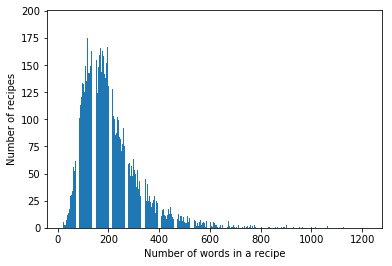

In [1301]:
plt.bar([item[0] for item in words_per_recipe.items()], [item[1] for item in words_per_recipe.items()])
plt.xlabel("Number of words in a recipe")
plt.ylabel("Number of recipes")

Distribution of the size of recipes in characters:

In [1302]:
chars_per_recipe = Counter([len(recipe) for recipe in recipes])

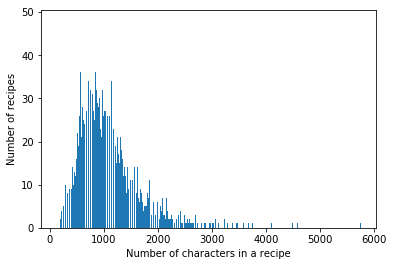

In [1303]:
plt.bar([item[0] for item in chars_per_recipe.items()], [item[1] for item in chars_per_recipe.items()])
plt.xlabel("Number of characters in a recipe")
plt.ylabel("Number of recipes")

In [1185]:
len_per_word = Counter([len(word) for word in vocabulary])

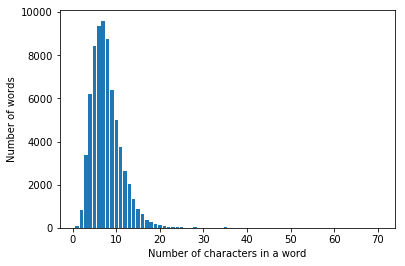

In [1186]:
plt.bar([item[0] for item in len_per_word.items()], [item[1] for item in len_per_word.items()])
plt.xlabel("Number of characters in a word")
plt.ylabel("Number of words")

Average word length:

In [1188]:
np.average([len(word) for word in vocabulary])

7.7467313998552019

Standard deviation of word length:

In [1190]:
np.std([len(word) for word in vocabulary])

3.4825802607693266

In [1390]:
char_vocabulary = Counter([ch for recipe in recipes for ch in recipe])

In [1391]:
char_vocabulary

Counter({'\x00': 5,
         '\x02': 1,
         '\t': 300,
         '\n': 1126537,
         '\x0b': 1,
         '\x0c': 4,
         '\x14': 1165,
         '\x16': 1,
         '\x1d': 1,
         ' ': 8798644,
         '!': 3423,
         '"': 17401,
         '#': 1789,
         '$': 391,
         '%': 3190,
         '&': 14463,
         "'": 16458,
         '(': 41977,
         ')': 41479,
         '*': 18527,
         '+': 9377,
         ',': 319369,
         '-': 494997,
         '.': 395667,
         '/': 134215,
         '0': 65465,
         '1': 317605,
         '2': 184138,
         '3': 85463,
         '4': 94894,
         '5': 53860,
         '6': 32681,
         '7': 13522,
         '8': 28583,
         '9': 26906,
         ':': 148221,
         ';': 55572,
         '<': 1584,
         '=': 14721,
         '>': 2092,
         '?': 488,
         '@': 4391,
         'A': 163433,
         'B': 114324,
         'C': 231292,
         'D': 78070,
         'E': 154820,
         'F':

#### Training the character language model

In [1310]:
def split_dataset(recipes):
    """
    Splits the dataset into 80% train, 10% validation and 10% test
    """
    num_of_recipes = len(recipes)
    permut_recipes = np.random.permutation(recipes)
    train = permut_recipes[:int(num_of_recipes*0.8)]
    valid = permut_recipes[int(num_of_recipes*0.8):int(num_of_recipes*0.9)]
    test = permut_recipes[int(num_of_recipes*0.9):]
    return train, valid, test

In [1311]:
train, valid, test = split_dataset(recipes)

In [1312]:
len(train)

26370

In [1360]:
print(train[0])


 
      Title: BUTTERMILK BROWN SUGAR POUND CAKE
 Categories: Cakes
      Yield: 12 Servings
 
  2 1/2 c  All-purpose flour
      1 ts Baking powder
    1/2 ts Baking soda
    1/8 ts Salt
      1 c  Unsalted butter, at room
           -temperature (2 sticks)
      2 c  Firmly packed light brown
           -sugar
      3    Eggs
      1 ts Vanilla
    1/4 ts Anise extract
      1 c  Buttermilk
           Orange Marmalade (Optional)
           Grated rind of one orange
           -(Optional)
    1/2 c  Plumped currants *
 
  * NOTE:  To plump currants, cover with boiling water in a small cup
  and let stand for 10 minutes.  Drain,
  
  Preheat the oven to Moderate (350F).  Grease a 10-inch tube pan. Line
  the bottom with waxed paper.  Grease and dust with flour, tapping out
  the excess.
  
  Stir together the flour, baking powder, baking soda, and salt in a
  large bowl.  Beat the butter and brown sugar in another large bowl
  for about 3 minutes, until light and fluffy, scraping down

Now we will build a model that is very similar to the word model.

In [1353]:
def train_char_lm_recipes(recipes, n=7):
    """
    ngram model that counts the number of times the a chracter ch comes after n-1 chracters history
    """
    lm = defaultdict(FreqDist)
    for recipe in recipes:
        pad = "~" * (n-1)
        recipe = pad + recipe + "~"
        for i in range(len(recipe)-n+1):
            history, char = recipe[i:i+n-1], recipe[i+n-1]
            lm[history][char]+=1
    return lm

#### Character language model evaluation


As before, for perplexity computation we need smoothing, otherwise the perplexity will be infinity. We will use the add 1 smoothing.

In [1392]:
def prob_MLE_addk_smoothing_chars(history, ch, n, model, k=1):
    char_count = 0
    history_count = 0
    if n == 1:
        char_count = model[ch]
        history_count = model.N()
    else:
        if history in model:
            history_count = model[history].N()
            if ch in model[history]:
                char_count = model[history][ch]
            
    V = len(char_vocabulary)
    prob = (char_count + k)/(history_count + (V*k))
    
    return prob

In [1397]:
from math import log
def entropy_chars(texts, n, model, prob_func, alpha=1):
        """
        Calculate the approximate cross-entropy of the n-gram model for a
        given evaluation texts.
        This is the average log probability of each character in the text.

        :param texts: texts for evaluation
        :type sents: list(str)
        :param n: the n of n-gram model
        :param model: ngram model
        :param prob_func: probability function to compute P(word|history)
        :param alpha: hyperparameter
        """
        
        e = 0.0
        N = 0
        for text in texts:
            pad = "~" *(n-1)
            N += len(text) + 1 #include the end of sent tokens to the total count
            text = pad + text + "~"
            for i in range(len(text)-n+1):
                history, ch = text[i:i+n-1], text[i+n-1]
                prob = prob_func(history, ch, n, model, alpha)
                e += log(prob, 2)
        
        return -e / N

In [1438]:
def perplexity_chars(texts, n, model, prob_func, alpha=1):
    return 2**entropy_chars(texts, n, model, prob_func, alpha)

Now we will train our model on the trainig data for n=5,7,10,12 and measure the perplexity

In [1399]:
char_models = {n:train_char_lm_recipes(train, n) for n in [5,7,10,12]}

In [1439]:
perplexities = []
for n in [5,7,10,12]:
    perplexities.append(perplexity_chars(valid, n, char_models[n], prob_MLE_addk_smoothing_chars, alpha=1))

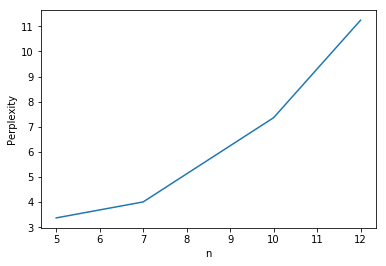

In [1441]:
plt.plot([5,7,10,12], perplexities)
plt.xlabel("n")
plt.ylabel("Perplexity")

As can be seen by the plot, the perplexity grows as n grows. Again, like with the word model, I suspect this is because the smoothing underestimates P(char|history) when n grows (the length of history grows). More characters were not seen in the train dataset in the context of some history.

As perplexity is not helpful here, we will test our model by generating recipes for different n.

In [1442]:
def generate_recipe(model, seed, n, num_of_chars=1000):
    '''
    generates a text given a seed using MLE probability
    '''
    history = seed
    out = history
  
    ch = MLEProbDist(model[history]).generate()
    i = 0
    while ch != "~" or i<num_of_chars: #keep generating words until an "end of recipe" mark
        out += ch
        history = history[-n+2:] + ch
        ch = MLEProbDist(model[history]).generate()
        i += 1
    return out

In [1433]:
n = 5
generated_recipe = generate_recipe(char_models[n], "~"*(n-1), n)
print(generated_recipe)

~~~~
 
  Cold Reductionalkalike notic
     Title: FIR: 233 casses, oranges
            1 tb Buttermission
  oils. Carrots; brush the Dean's Soy saucepan
  celerial, cornstand dill, and
           -cubed, formulate flour. OR 15 minutes on each lettuce into and be chopped
    1    2 ts Black skillet over med ingreased in a littles, 1 c  Butter
  until give oil and with fruity (from head carbohydrate.
    2 c  Brown
       1 tb Worcested
     1 1/2 c  Chopped and well. Skimming accompletely cracker cream rum
  :    2/3 c  Water until egg sugar, salt. Put two bit margarine Yeasts up to 375F until
         15 minutes.  Sliced
  1/4 c  Chop thinner, grapefruits
     2 c  Chopped
       Title: FARINADE HEN
 Categories: Meats, or made (Nation
     Sprinkle slightly for $12.9g (3%)
         10 minutes turn the
  TXFT40A@Prodigy, Inc. Electric blender. On high 6
  heat oiler top. Margarinator
    Yield: 18 g CHOCOLATE-ECLAIR. SPINACHED PANCAKE
 Categories on packer can hot with a
  white, Contin

In [1402]:
n = 7
generated_recipe = generate_recipe(char_models[n], "~"*(n-1), n)
print(generated_recipe)



~~~~~~
 
        Shredded cheese, sugar, and cook on high heat 5 minutes more. On
  the hot water together use. Then push braid
       Salt & peppers magazine, December, Dill, fresh rosemary
       1    Shred the wine
  then rolls at Home_.
  
  Serve piping
 
  PREPARE ICING, in small pieces.
  
  Source: "Great Good"
  Submitted
  1 1/2 c  Unsalted butter or Mondadori Editor's favorite Recipe made in small butter
       8 tb Sugar
       or until smooth.
  
  *  The next day.  It is
  tender. Remove from: * Oregon
  Hazelnut Marketing Board
      2 lg Onion; chopped crepe pan. Place in a saucepan and heat sauce
    1/4 cup sugar and yeast into 8 servings
 
       1    Eggs, well and add water; bake for the vanilla. Add apple as a medium
        2 x  Sm Sweet pepper
    1. Place chickened. Finely chopped fresh into julienne straw mushrooms and refrigerate in blended. Add spices
        1    Jalapeno
  in ham cut into 8 rectangle.
  
  Oven 5
  minutes. Serve with an electric mixer t

With n=5,7 the recipe doesn't look good. The structure is not as a recipe structure, the instructions come before the ingrediants, the sentences are messy.

In [1413]:
n = 10
generated_recipe = generate_recipe(char_models[n], "~"*(n-1), n)
print(generated_recipe)



~~~~~~~~~
 
      Title: HOLIDAY OATMEAL COOKIES
 Categories: Breads2, Brdmachine
      2 tb Lemon Juices & Lemon Rind; Grated
      1 c  Water
             -chiles
  cascabel 18 peppercorns, allspice. Warm
  tortilla flour or wheat germ and powdered
 
  Rub roast them lightly overlapping. Almond paste and corn syrup or honey.  Pour over the top is a nice brown
  sugar would
  other seasoning and pepper -- seeded and chopped
       margarine
      1 tb Wine vinegar
     10 oz Grapefruit Halves
         -dish 6 layers. Bake for 35 to 45 minutes. Cool
  slightly closed jar. Use as much color of rice papers with fingers, to
  make a little dollop of whipped cream mixture. Cook over medium
  head. EYE PUFFINESS: Teabags, slightly.
  Place peas, oil, beaten egg whites until meat thermometer. Stir chicken.
  
  You can use catsup, tomato paste.
  
  BLINTZES
 Categories: Vegetables are tender, brushing with a cover. Freeze 1/2 cup apple juice concentrate (e.g.
  :       Georgetown, Delawar

For n=10 it starts nicely, with title, categories and ingredients. After the instructions it seems that a new recipe description is created.

In [1416]:
n=12
generated_recipe = generate_recipe(char_models[n], "~"*(n-1), n)
print(generated_recipe)



~~~~~~~~~~~
 
      Title: CORNSTICKS
 Categories: Meats
      Yield: 1 Servings
 
      1 tb Water
      1    Egg
     20    minutes.
  
  Add potatoes (about 2 minutes or until toothpick inserted in center comes out clean, about 300 degrees for 16 minutes, or until
  it registers 160 degrees; otherwise,
  cut into bite-sized pieces. Can use
  leftovers here.
  
  *  All ingredients and process until smooth, thick frosting. Lay on plate
  and ground beef chuck eye steaks
      1 lb FRESH GREEN CHILE CHICKEN WITH SALT,
  ROSEMARY - Used in fruit sugar.
  Add 1/4 C Grand Marnier. Roll
  into a measuring spoons, measuring
  cup) and stir to coat well.
    In medium bowl, with an electric mixer beat whites and water. Chill.  Serve hot.
 

 



For n=12, this recipe looks like a real one. Let's generate some more.

In [1417]:
n=12
generated_recipe = generate_recipe(char_models[n], "~"*(n-1), n)
print(generated_recipe)



~~~~~~~~~~~
 
      Title: CLASSIC FRENCH-STYLE BAKED CHICKEN CASSEROLE
 Categories: Cheese/eggs, Vegetables
      Yield: 16 Servings
 
     80 g  Plain bread crumbs
    1/3 c  Curacao
 
  Blend 1/2 minutes.
  
  Set a wok over high heat,
  whisking constantly, for thirty days straight'."
  
  Storm has since honed her culinary purposes.  In common usage, the fruits with seeds of our choice;
  sesame oil
    1/2 c  Honey
            White angel food cake pan to a
  depth of 1/4". It should rise to double, about 45 minutes.Transfer to a small bowl combine beef, pasta, artichoke leaves. In
  a small cloth towel
  to drain. Sprinkle grated cheese,
             Cornstarch on a plate, pick an old one I have had the tips off the leaves finely. Heat half the bacon mixture, lifting
  pan with butter, about 5 minutes.
  
  Glaze:  In saucepan, and put through
  a large bowl until a rich brown solid pudding. Amaretto is also good, though not in use covered).
  Spread rolled dough.
  Set aside.

Again, the begining of the recipe looks nice. This is a very time consuming recipe since you have to "whisk constanly, for thirty days straight" :)

The problem ia that a new recipe starts after the first one. We will change the generate function to stop when a stop token in encountered or when we reached a 1000 characters (the average length of a recipe)

In [1427]:
n=12
generated_recipe = generate_recipe(char_models[n], "~"*(n-1), n)
print(generated_recipe)

~~~~~~~~~~~
 
      Title: BAKED ONIONS WITH CHEMICALS Although this torta is from Provence, its superb
  blending into the container, combine
      8 oz Self-raising flour
      2 tb Butter or margarine and milk into egg halves. Put a small saucepan and bring to a boil over medium heat for 25 minutes. Place
  rolls, point side down
  on it with a grapefruit
    1/2 c  Bisquick Baking Mix; Bisquick
      1    Teaspoo salt
 
   "Chile pastes are very tender; remove pans. Cool completely melted and mixture into large bowl, combine
  the tofu. Place the
  sauce has simmered for 10 minutes.  Add the broccoli and mushroom sp
    1/4 ts Salt
      2 tb Thyme; minced
      1 pt Canned corn; drained
     In skillet, transfer to a blender and coarse salt. Set aside. TO PREPARE DIP: In small skillet over low heat until butter melts
  and the peppers in large bowl, tossing just
  to blend. Drizzle liberally over the countertop to room temperature before using. To blanch, cover with a damp cloth, 

Baked onion with chemicals, yummy.

In [1431]:
n=12
generated_recipe = generate_recipe(char_models[n], "~"*(n-1), n)
print(generated_recipe)

~~~~~~~~~~~
 
      Title: CORNY STUFFED PEPPERS & TOMATO CREAM
 Categories: Fruits, Candies
      Yield: 1 Cake
 
           Recipe
 
  1 1/2 lb Fresh Asparagus is tender-crisp. Add vegetables and Lemon Rind; Grated
    1/3 c  Rasted pepitas or hulled
    1/2 ts Dijon mustard
  green.
  
  Wash the squash in a 350F oven, covered, 3-5 minutes, then reduce heat, and simmer for 10 minutes, stirring constantly; cool
  mixture and bay leaves. Mix well. Spoon this over rice.  Bake for 1 hour or until fish just flakes when poked
  with various meat stuffings either! I got the
  recipe calls for pimiento-
           Mayonaise
    1/2 ts oregano
            -Stuffing Mix
      4 c  Tomato sauce
           -cut into pieces approximately 360F and carefully to remove the meat from marinade and 2 tablespoons marinade. Grill chicken,
  turning the basic stuff,
  unembellished
  it somewhat (don't expect it
  to be slightly so they don't burn. (Traditionally the heart-shaped (or similar bowl, stir t

Well, the generated recipes are not perfect but they are also not bad. 
They start with a title, categories an 'yield'. Than the ingrediants and then the instructions. Sometimes there is \n in the middle of the sentence and suddenly the instructions become a list of ingredients. But overall, most words are existing words, the spacing is good, and on first glance it can look like a real recipe. Until you start to read the instructions and they don't make much sense.

We can keep generating recipes and pick only the best ones, and choose a better stop criteria.

## Part 2: Polynomial Curve Fitting

### 2.1 Synthetic Dataset Generation


In [636]:
import math
import numpy as np

In [976]:
def noise(x, f, sigma):
    """adds Gaussian noise N(0, sigma) noise to a vector"""
    return np.vectorize(f)(x) + np.array([(sigma * np.random.randn()) for i in range(len(x))]) 

def generateDataset(N, f, sigma):    
    x = np.linspace(0, 1, N)
    t = noise(x, f, sigma)
    
    return (x, t)

In [977]:
def sin2pi(x): return math.sin(2 * math.pi * x)

In [1285]:
N = 100
x, t = generateDataset(N, sin2pi, 0.03)

We generated a function (sin(2pix)) with some noise

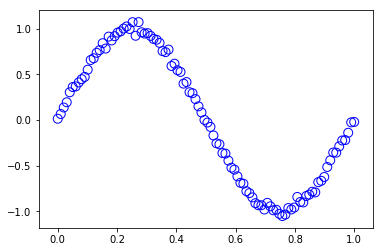

In [1286]:
plt.scatter(x, t, s=80, facecolors='none',  edgecolors='b')

I think the noise is more noticeble in a regular plot:

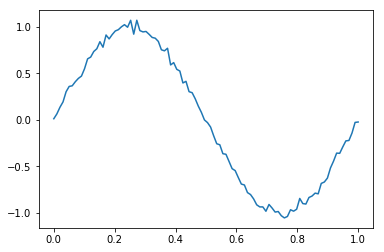

In [1287]:
plt.plot(x, t)

### 2.2 Polynomial Curve Fitting


We will attempt to learn the function y given a synthetic dataset (x, t). We will assume that y is a polinom of degree M and try to learn the sin(2pix) function.

In [981]:
def polynom(val, M):
    return np.array([val**i for i in range(M+1)])

In [982]:
def OptimizeLS(x, t, M):
    cols = M+1
    rows = len(t)
    
    phi = np.array([polynom(x[i], M) for i in range(rows)])
    prod = np.dot(phi.T, phi) 
    m = np.dot(np.linalg.inv(prod), phi.T)   
    w = np.dot(m, t)
    return w

In [983]:
def reverseOptimizeLS(x, t, M):
    return OptimizeLS(x, t, M)[::-1] #reverse the coefficiants

In [1455]:
def plot_polyfit(x, t, degs, org_func, polyfit_func):
    """
    Plots the original function, x points against org_func(x) with noise, xpoints against predicted polynoms
    with different degrees 
    """
    
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    
    x_sin = np.linspace(0, 1, 101)
    plt.plot(x_sin, [org_func(xi) for xi in x_sin], c=colors[0])#original function
    plt.scatter(x, t , s=80, facecolors='none',  edgecolors=colors[1])#noisy function
    
    for i, M in enumerate(degs, 2):
        w = polyfit_func(x, t, M)
        p = np.poly1d(w)
        y = np.array([p(x[j]) for j in range(len(x))])
        plt.scatter(x,y, marker='.', c=colors[i])#polynoms
        
    plt.legend(['sin(2px)', 'noisy sin(2px)']+['M='+str(M) for M in degs], loc='upper right')
    

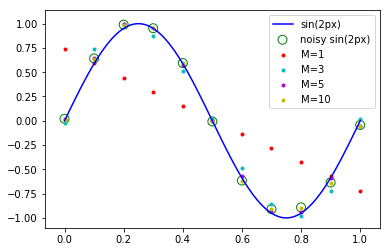

In [1123]:
N = 11
x, t = generateDataset(N, sin2pi, 0.03)
degs = [1, 3, 5, 10]
plot_polyfit(x, t, degs, sin2pi, reverseOptimizeLS)

We can observe that the polynomial function with M=1 does not estimate well the sin(2px) function, which makes sense as it is a linear function.
M=3 is very close, and for M>=5 it seems like the coefficiants became finely tuned to the noisy sin(2px) function. 

### 2.3 Polynomial Curve Fitting with Regularization


To solve this overfitting we observed, we can try to pick the best order of a ploynom, or we can use regularization. It involves adding a penalty term to the error function in order to discourage
the coefficients from reaching large values

First, we need a training, dev and test data which will help us choose the penalty (lambda). 

To construct a development set, we will extend our synthetic dataset construction function to return 3 samples: one for training, one for development and one for testing.

In [1456]:
def generateDataset3(N, f, sigma):
    """
    returns 3 pairs of vectors of size N each, 
    (xtest, ttest), (xvalidate, tvalidate) and (xtrain, ttrain).
    The target values are generated with Gaussian noise N(0, sigma).
    """
    x = np.linspace(0, 1, 3*N)
    np.random.shuffle(x)
    
    xtrain = x[:N]
    xtrain.sort()
    ttrain = noise(xtrain, f, sigma)
    
    xdev = x[N:2*N]
    xdev.sort()
    tdev = noise(xdev, f, sigma)
    
    xtest = x[2*N:]
    xtest.sort()
    ttest = noise(xtest, f, sigma)
    
    return (xtrain, ttrain), (xdev, tdev), (xtest, ttest)

Lets see what we get

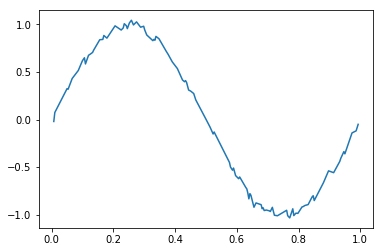

In [1110]:
N = 101
(xtrain, ttrain), (xdev, tdev), (xtest, ttest) = generateDataset3(N, sin2pi, 0.03)

plt.plot(xtrain, ttrain)

Now, we will change the OptimizePls function to return optimal parameters w_PLS given M and lambda.

In [1457]:
def optimizePLS(x, t, M, lam):
    """
    returns the optimal parameters wPLS given M and lambda
    """
    cols = M+1
    rows = len(t)
    
    phi = np.array([polynom(x[i], M) for i in range(rows)])
    prod = np.dot(phi.T, phi) 
    
    m = np.dot(np.linalg.inv(prod + np.identity(M+1)*lam), phi.T)   
    w = np.dot(m, t)
    return w

We will try and optimize the value of λ by varying the value of ln(λ) from -40 to -20 on the development set.

In [1111]:
def norm_error(x, t, y):
    """return the normalized error of t against y"""
    diff = t-y
    return math.sqrt(sum(elem**2 for elem in diff))/len(x)

In [1011]:
def norm_errors(x, t, polynoms):
    """return normalized errors of t against y for each y=p(x) in polynoms"""
    norm_errors = []
    for p in polynoms:
        y = np.array([p(x[j]) for j in range(len(x))])
        norm_errors.append(norm_error(x, t, y))
    return norm_errors

In [1276]:
def plot_errors(N):
    (xtrain, ttrain), (xdev, tdev), (xtest, ttest) = generateDataset3(N, sin2pi, 0.03)

    lambdas = [1/math.exp(i) for i in range(40, 19, -5)]
    ln_lambdas = list(range(-40, -19, 5))
    M = 9

    polynoms = []

    for lam in lambdas:
        w = optimizePLS(xtrain, ttrain, M, lam)
        p = np.poly1d(w[::-1])
        polynoms.append(p)

    plt.plot(ln_lambdas, norm_errors(xtrain, ttrain, polynoms))
    plt.plot(ln_lambdas, norm_errors(xdev, tdev, polynoms))
    plt.plot(ln_lambdas, norm_errors(xtest, ttest, polynoms))
    plt.legend(['train', 'dev', 'test'], loc='upper right')
    plt.xlabel("ln(λ)")
    plt.ylabel("error")

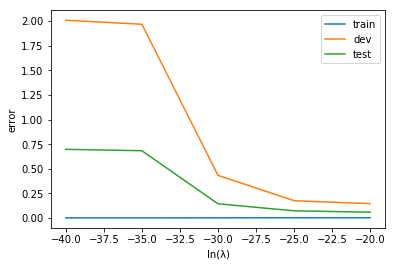

In [1280]:
N = 11
plot_errors(N)

The error on the train dataset is very low and pretty constant, which makes sense because we created a polynom that fits best to the train data.

The error on the test and dev data decreases as λ is larger. For λ=-20 the overfitting has been supressed

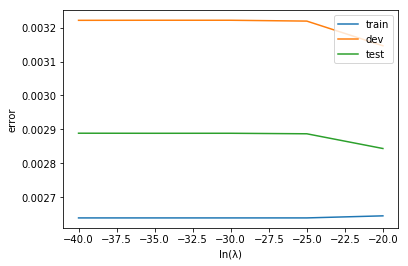

In [1282]:
N = 101
plot_errors(N)

In this graph we can observe a similar trend. Although the error and the decrease of error in the dev and test datasets is much smaller.

Now we will write a function that chooses λ that gives the smallest error on the dev dataset

In [1283]:
def optimizePLS2(xt, tt, xv, tv, M):
    """
    Selects the best value λ given a dataset for training (xt, tt) and a development test (xv, tv)
    """
    lambdas = [1/math.exp(i) for i in range(40, 19, -5)]
    ln_lambdas = list(range(-40, -19, 5))

    polynoms = []

    for lam in lambdas:
        w = optimizePLS(xt, tt, M, lam)
        p = np.poly1d(w[::-1])
        polynoms.append(p)
        
    lam_index = np.argmin(norm_errors(xv, tv, polynoms))
    return ln_lambdas[lam_index]

In [1101]:
N = 11
(xtrain, ttrain), (xdev, tdev), (xtest, ttest) = generateDataset3(N, sin2pi, 0.03)
M = 9 
optimizePLS2(xtrain, ttrain, xdev, tdev, M)

-20

Indeed as shown in the graph, the best λ is -20. We will use this λ to find w that best fits our dataset and see how it looks.

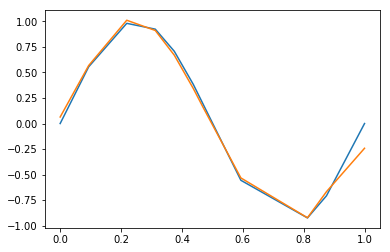

In [1104]:
M=9
w = optimizePLS(xtrain, ttrain, M, 1/math.exp(20))
p = np.poly1d(w[::-1])
ytest = np.array([p(xtest[j]) for j in range(len(xtest))])
plt.plot(xtest, [sin2pi(xi) for xi in xtest])
plt.plot(xtest, ytest)

We can see that with M=9 and ln(lambda)=-20 our polynom is a good representation of the function sin(2pix) 

### 2.4 Probabilistic Regression Framework

We further extend the probabilistic model by considering a Bayesian approach to the estimation of this probabilistic model instead of the maximum likelihood estimator (which is known to over-fit the dataset). 

In the Bayesian approach, we do not learn an optimal value for the parameter w, but instead, marginalize out this parameter and directly learn the predictive distribution.

In [1274]:
def bayesianEstimator(x, t, M, alpha, sigma2):
    """
    Given the dataset (x, t) of size N, and the parameters M, alpha, and sigma2 (the variance),
    this function returns a tuple of 2 functions (m(x) var(x)) which are the mean and variance
    of the predictive distribution inferred from the dataset, based on the parameters and the
    normal prior over w.
    """
    N = len(x)

    #inv(S)
    prod_mat = np.zeros((M+1, M+1))
    for i in range(N):
        phi_xi = polynom(x[i], M)
        prod_mat += np.outer(phi_xi, phi_xi.T)
    S_inv = alpha * np.eye(M+1) + prod_mat/sigma2

    S = np.linalg.inv(S_inv)
        
    def m(new_x):
        phi_t = polynom(new_x, M).T 
        rsum = np.zeros(M+1)
        for i in range(N):
            rsum += polynom(x[i], M)*t[i]
        phi_tS = np.dot(phi_t, S)
        return np.dot(phi_tS, rsum)/sigma2

    def var(new_x):
        phi_x = polynom(new_x, M)
        prod = np.dot(np.dot(phi_x.T, S), phi_x)
        return sigma2 + prod
        
    return (m, var)

In [1251]:
def plotBayesianEstimator(N):
    (xtrain, ttrain), (xdev, tdev), (xtest, ttest) = generateDataset3(N, sin2pi, 0.03)
    M = 9
    alpha = 0.005
    sigma2 = 1/11.1

    m, var = bayesianEstimator(xtrain, ttrain, M, alpha, sigma2)

    plt.figure(figsize=(8, 6))
    x_sin = np.linspace(0, 1, 101)
    
    #mean plot
    plt.plot(xtest, [m(xi) for xi in xtest], c='r')
    #confidence interval
    plt.fill_between(xtest, [m(xi)-math.sqrt(var(xi)) for xi in xtest],  [m(xi)+math.sqrt(var(xi)) for xi in xtest], color='r',
                            alpha=0.2)
    #train data scatter plot
    plt.scatter(xtrain, ttrain, s=50, facecolors='none',  edgecolors='b')
    #sin2px plot
    plt.plot(x_sin, [sin2pi(xi) for xi in x_sin], c='g')
    
    plt.legend(['Mean', "sin(2pix)", "Confidence interval", "Train data"], loc='upper right')

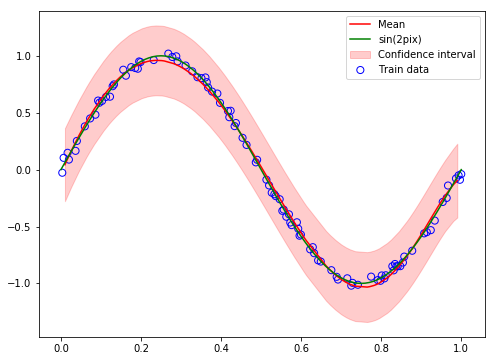

In [1275]:
N = 101
plotBayesianEstimator(N)

In this graph we can see that the mean is really close to the original function sin(2pix)

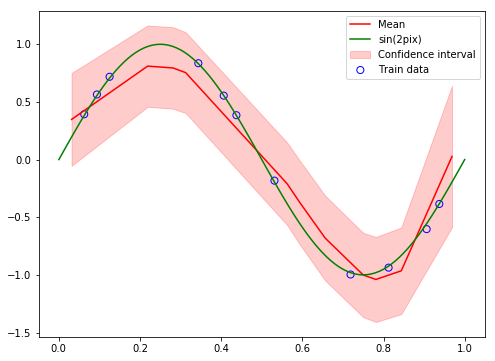

In [1256]:
N = 11
plotBayesianEstimator(N)

In the case where N=11, the height of the confidence interval is larger as we have less data points to learn from.

The height of the band can vary by the density of the sampled data points. For some interval that contains many points, the variance should be smaller leading to a small band height. On the other hand, for an interval with only a few points the variance should be higher leading to a large band height.